In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

#### Load Data -- Continuous

In [55]:
train_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/model_data/train.csv")
test_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/model_data/test.csv")
x_train, y_train = train_pd.values[:,:-1], train_pd.values[:,-1]
x_test, y_test = test_pd.values[:,:-1], test_pd.values[:,-1]

In [30]:
cols = train_pd.columns[:-1]

#### Modeling

In [56]:
ebm = ExplainableBoostingClassifier(feature_names=cols, n_estimators=40, 
                                    max_tree_splits=4, holdout_size=0.1, holdout_split=0.1).fit(x_train, y_train)

In [57]:
ebm.score(x_train, y_train)

0.6845809341010877

In [58]:
ebm.score(x_test, y_test)

0.6434316353887399

In [59]:
ebm_global = ebm.explain_global(name = 'EBM')
show(ebm_global)

### CV

In [60]:
combined = np.r_[train_pd, test_pd]
X, Y = combined[:, :-1], combined[:,-1]

Text(0,0.5,'True Positive Rate')

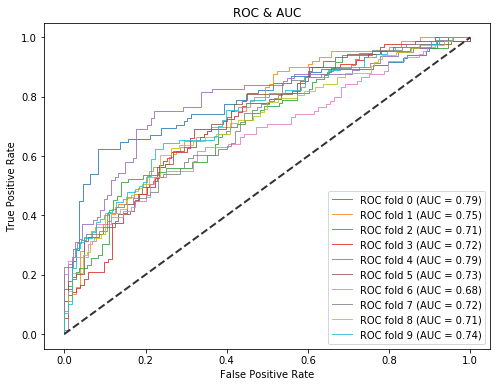

In [61]:
cv = KFold(n_splits=10, random_state=816, shuffle=True)
train_acc = []
test_acc = []

i = 0
plt.figure(figsize=(8,6))
for train, test in cv.split(X, Y):
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    
    test_prob = ebm.predict_proba(X_test)[:,1]
    
    train_acc.append(ebm.score(X_train, Y_train))
    test_acc.append(ebm.score(X_test, Y_test))
    
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_test, test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [62]:
np.mean(train_acc), np.mean(test_acc)

(0.6766524190908294, 0.6766144970888306)